# Lab 03: Lot Sizing for Individual Items with Time-Varying Demand

**Objective:** This notebook implements and compares six classic lot-sizing policies (plus the optimal Wagner-Whitin algorithm) for a single item with time-varying demand over a 12-month horizon. The goal is to find the replenishment plan that minimizes total costs, which are composed of ordering and holding costs.

## 1. Setup and Data Extraction

First, we import the necessary libraries and define the problem parameters as extracted from the provided document.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display, HTML

# --- Data Extracted from PDF ---

# Base Case Constants
A_base = 20.0  # Ordering cost per order ($)
v_base = 2.0   # Unit value for carrying cost ($/unit)
r_base = 0.24  # Annual carrying cost rate ($/$/year)

# 12-Month Demand Forecast D(j)
# The demand array is 0-indexed for easier slicing in Python (Month 1 = index 0)
D_base = np.array([50, 70, 100, 120, 110, 100, 100, 80, 120, 70, 60, 40])

# --- Derived Holding Cost & Operational Rules ---

def calculate_monthly_holding_cost(r, v):
    """Calculates the per unit, per month holding cost."""
    return (r * v) / 12

h_base = calculate_monthly_holding_cost(r_base, v_base)

print(f"--- Base Case Parameters ---")
print(f"Ordering Cost (A): ${A_base:.2f}")
print(f"Annual Carrying Rate (r): {r_base:.2f}")
print(f"Unit Value (v): ${v_base:.2f}")
print(f"Derived Monthly Holding Cost (h): ${h_base:.4f} per unit per month")
print(f"Demand Forecast (D): {D_base.tolist()}")
print(f"Total Demand: {np.sum(D_base)} units")

--- Base Case Parameters ---
Ordering Cost (A): $20.00
Annual Carrying Rate (r): 0.24
Unit Value (v): $2.00
Derived Monthly Holding Cost (h): $0.0400 per unit per month
Demand Forecast (D): [50, 70, 100, 120, 110, 100, 100, 80, 120, 70, 60, 40]
Total Demand: 1020 units


### Holding Cost Convention

As specified, holding costs are calculated based on the number of full months an item is held in inventory *before* its consumption month. If an order placed in month `t` covers demand for months `t` through `t+T-1`:
- Demand `D(t)` incurs **no** holding cost.
- Demand `D(t+1)` is held for 1 month, costing `h * D(t+1)`.
- Demand `D(t+2)` is held for 2 months, costing `2 * h * D(t+2)`.

A simpler, equivalent way to calculate the total holding cost for the entire horizon is `Total Holding Cost = h * sum(Ending Inventory)`. This is because the ending inventory of any given month `j` is precisely the sum of demands for future months that have already been ordered but not yet consumed.

## 2. Helper Functions for Simulation and Costing

These functions provide a standardized framework for creating replenishment plans and calculating their associated costs.

In [2]:
def create_plan_template(D):
    """Creates a blank DataFrame to be filled by a policy."""
    n_periods = len(D)
    df = pd.DataFrame({
        'Month': np.arange(1, n_periods + 1),
        'Replenishment Qty': np.zeros(n_periods, dtype=int),
        'Starting Inv': np.zeros(n_periods, dtype=int),
        'Demand': D,
        'Ending Inv': np.zeros(n_periods, dtype=int)
    })
    return df

def simulate_inventory_flow(plan_df):
    """Fills in inventory levels based on replenishment quantities."""
    for i in range(len(plan_df)):
        if i == 0:
            plan_df.loc[i, 'Starting Inv'] = 0
        else:
            plan_df.loc[i, 'Starting Inv'] = plan_df.loc[i-1, 'Ending Inv']

        plan_df.loc[i, 'Ending Inv'] = (
            plan_df.loc[i, 'Starting Inv'] +
            plan_df.loc[i, 'Replenishment Qty'] -
            plan_df.loc[i, 'Demand']
        )
    return plan_df

def calculate_costs(plan_df, A, h):
    """Calculates ordering, holding, and total costs for a given plan."""
    num_orders = (plan_df['Replenishment Qty'] > 0).sum()
    ordering_cost = num_orders * A

    # Total holding cost = h * sum of all monthly ending inventories
    holding_cost = plan_df['Ending Inv'].sum() * h

    total_cost = ordering_cost + holding_cost

    return {
        'Policy': '', # To be filled in later
        '# Orders': num_orders,
        'Ordering Cost': ordering_cost,
        'Holding Cost': holding_cost,
        'Total Cost': total_cost
    }

def format_plan_df(df):
    """Adds final columns for better readability."""
    df['Order? (Y/N)'] = df['Replenishment Qty'].apply(lambda x: 'Y' if x > 0 else 'N')
    styled_df = df.style.format({
        'Replenishment Qty': '{:,.0f}',
        'Starting Inv': '{:,.0f}',
        'Demand': '{:,.0f}',
        'Ending Inv': '{:,.0f}'
    }).hide(axis='index')
    return styled_df

## 3. Lot-Sizing Policy Implementations

Each policy is implemented as a separate function that generates a full 12-month replenishment plan.

### a) Fixed EOQ (Rounded to Months of Supply)

This policy calculates a fixed order interval `T` based on the Economic Order Quantity formula using the *average* monthly demand. At each replenishment, an order is placed to cover the *actual* demand for the next `T` months.

In [3]:
def policy_fixed_eoq(A, h, D):
    plan_df = create_plan_template(D)
    n_periods = len(D)

    # 1. Compute average monthly demand
    d_bar = np.mean(D)

    # 2. Convert to an "EOQ in months" and round
    if h > 0 and d_bar > 0:
        T_eoq = np.sqrt((2 * A) / (h * d_bar))
        T = int(np.round(T_eoq))
        T = max(1, T) # T must be at least 1
    else:
        T = 1

    print(f"Average Demand (d_bar): {d_bar:.2f}")
    print(f"EOQ in Months (T_eoq): {T_eoq:.2f}")
    print(f"Rounded Time Supply (T): {T} months")

    # 3. Create replenishment plan
    current_month = 0
    while current_month < n_periods:
        # Adjust T for the last lot to end with zero inventory
        periods_to_cover = min(T, n_periods - current_month)

        # Calculate order quantity
        order_qty = np.sum(D[current_month : current_month + periods_to_cover])
        plan_df.loc[current_month, 'Replenishment Qty'] = order_qty

        current_month += periods_to_cover

    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

### b) Fixed Time Supply

This policy is identical to (a) for this specific problem. The initial `T` is calculated once based on average demand and then applied throughout the horizon. Since the logic for (a) also uses a single, unchanging average demand, the resulting `T` is the same for every cycle. Therefore, the plans and costs will be identical.

In [4]:
def policy_fixed_time_supply(A, h, D):
    print("This policy is identical to Fixed EOQ for this problem statement.")
    return policy_fixed_eoq(A, h, D)

### c) Cost per Unit Heuristic (Part Period Balancing)

At each replenishment decision, this heuristic calculates the Average Cost per Unit (ACU) for ordering various quantities (covering `T=1, 2, 3...` months). It chooses the time supply `T` that minimizes this cost per unit, aiming to balance ordering and holding costs for the batch.

In [5]:
def policy_cost_per_unit(A, h, D):
    plan_df = create_plan_template(D)
    n_periods = len(D)
    t = 0 # Start month for the next order (0-indexed)

    while t < n_periods:
        best_T = -1
        min_acu = float('inf')

        # Iterate through possible coverage periods (T)
        for T in range(1, n_periods - t + 1):
            # Demand for the months t to t+T-1
            demands_in_window = D[t : t + T]
            total_demand_in_window = np.sum(demands_in_window)

            # Calculate holding cost for this window
            holding_cost = 0
            for k in range(T):
                holding_cost += h * k * D[t+k]

            # Calculate Average Cost per Unit (ACU)
            if total_demand_in_window > 0:
                acu = (A + holding_cost) / total_demand_in_window
            else:
                acu = float('inf') # Avoid division by zero

            if acu < min_acu:
                min_acu = acu
                best_T = T

        # Place the order for the best T
        order_qty = np.sum(D[t : t + best_T])
        plan_df.loc[t, 'Replenishment Qty'] = order_qty

        # Advance to the next replenishment month
        t += best_T

    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

### d) Silver-Meal Heuristic

This heuristic is similar to Cost-per-Unit but aims to minimize the Average Cost per Month (ACM). It extends the coverage period `T` as long as the cost per month is decreasing. Once the cost per month starts to increase, it fixes the order to cover the previous number of months (`T-1`).

In [6]:
def policy_silver_meal(A, h, D):
    plan_df = create_plan_template(D)
    n_periods = len(D)
    t = 0 # Start month for the next order (0-indexed)

    while t < n_periods:
        prev_acm = float('inf')
        best_T = 1

        # Iterate through possible coverage periods (T)
        for T in range(1, n_periods - t + 1):
            holding_cost = 0
            for k in range(T):
                holding_cost += h * k * D[t+k]

            acm = (A + holding_cost) / T

            if acm > prev_acm:
                best_T = T - 1
                break
            else:
                best_T = T
                prev_acm = acm

        # Place the order for the best T
        order_qty = np.sum(D[t : t + best_T])
        plan_df.loc[t, 'Replenishment Qty'] = order_qty

        # Advance to the next replenishment month
        t += best_T

    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

### e) All-at-Once

A single replenishment is made at the beginning of month 1 to cover the entire 12-month demand. This minimizes ordering costs but typically results in very high holding costs.

In [7]:
def policy_all_at_once(A, h, D):
    plan_df = create_plan_template(D)
    # Order total demand in the first month
    plan_df.loc[0, 'Replenishment Qty'] = np.sum(D)
    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

### f) Lot-for-Lot (Every Month)

An order is placed at the beginning of every month to meet that month's demand exactly. This minimizes holding costs (to zero) but incurs the maximum possible number of ordering costs.

In [8]:
def policy_lot_for_lot(A, h, D):
    plan_df = create_plan_template(D)
    # Order demand for each month
    plan_df['Replenishment Qty'] = D
    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

### g) Wagner-Whitin Algorithm (Bonus)

This dynamic programming algorithm guarantees the optimal solution. It works backward from the end of the horizon, calculating the minimum possible cost to satisfy demand from each period `t` to the end. It then uses these calculated costs to build the optimal forward plan.

In [9]:
def policy_wagner_whitin(A, h, D):
    n_periods = len(D)

    # DP state: C[t] = min cost for periods t through n_periods
    C = np.zeros(n_periods + 1)
    # P[t] stores the end period k of the optimal order placed at t
    P = np.zeros(n_periods, dtype=int)

    # Solve backwards from the last period
    for t in range(n_periods - 1, -1, -1):
        min_cost = float('inf')
        best_k = -1

        # Try ordering at t to cover demand up to period k
        for k in range(t, n_periods):
            # Calculate cost of this single order (A + holding cost)
            holding_cost = 0
            for j in range(t, k + 1):
                holding_cost += h * (j - t) * D[j]

            current_cost = A + holding_cost + C[k+1]

            if current_cost < min_cost:
                min_cost = current_cost
                best_k = k

        C[t] = min_cost
        P[t] = best_k

    # Reconstruct the optimal plan by moving forward
    plan_df = create_plan_template(D)
    t = 0
    while t < n_periods:
        end_period = P[t]
        order_qty = np.sum(D[t : end_period + 1])
        plan_df.loc[t, 'Replenishment Qty'] = order_qty
        t = end_period + 1

    final_plan = simulate_inventory_flow(plan_df)
    return final_plan

## 4. Per-Policy Analysis & Execution

We now run each policy, display its detailed month-by-month plan, and calculate the associated costs.

In [10]:
policies = {
    "a) Fixed EOQ": policy_fixed_eoq,
    "b) Fixed Time Supply": policy_fixed_time_supply,
    "c) Cost per Unit": policy_cost_per_unit,
    "d) Silver-Meal": policy_silver_meal,
    "e) All-at-Once": policy_all_at_once,
    "f) Lot-for-Lot": policy_lot_for_lot,
    "g) Wagner-Whitin (Optimal)": policy_wagner_whitin,
}

results_list = []
plan_dfs = {}

def run_all_policies(A, r, v, D):
    h = calculate_monthly_holding_cost(r, v)
    all_results = []
    all_plans = {}

    print("--- Running All Policies ---\n")
    for name, func in policies.items():
        print(f"--- {name} ---")
        plan_df = func(A, h, D)
        cost_summary = calculate_costs(plan_df, A, h)
        cost_summary['Policy'] = name

        all_results.append(cost_summary)
        all_plans[name] = plan_df

        display(format_plan_df(plan_df))
        print(f"Ordering Cost: ${cost_summary['Ordering Cost']:.2f}, Holding Cost: ${cost_summary['Holding Cost']:.2f}, Total Cost: ${cost_summary['Total Cost']:.2f}\n")
        print("="*80 + "\n")

    summary_df = pd.DataFrame(all_results).sort_values('Total Cost').reset_index(drop=True)
    return summary_df, all_plans

# Run with base case parameters
summary_table, plan_dfs = run_all_policies(A_base, r_base, v_base, D_base)

--- Running All Policies ---

--- a) Fixed EOQ ---
Average Demand (d_bar): 85.00
EOQ in Months (T_eoq): 3.43
Rounded Time Supply (T): 3 months


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,220,0,50,170,Y
2,0,170,70,100,N
3,0,100,100,0,N
4,330,0,120,210,Y
5,0,210,110,100,N
6,0,100,100,0,N
7,300,0,100,200,Y
8,0,200,80,120,N
9,0,120,120,0,N
10,170,0,70,100,Y


Ordering Cost: $80.00, Holding Cost: $41.60, Total Cost: $121.60


--- b) Fixed Time Supply ---
This policy is identical to Fixed EOQ for this problem statement.
Average Demand (d_bar): 85.00
EOQ in Months (T_eoq): 3.43
Rounded Time Supply (T): 3 months


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,220,0,50,170,Y
2,0,170,70,100,N
3,0,100,100,0,N
4,330,0,120,210,Y
5,0,210,110,100,N
6,0,100,100,0,N
7,300,0,100,200,Y
8,0,200,80,120,N
9,0,120,120,0,N
10,170,0,70,100,Y


Ordering Cost: $80.00, Holding Cost: $41.60, Total Cost: $121.60


--- c) Cost per Unit ---


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,340,0,50,290,Y
2,0,290,70,220,N
3,0,220,100,120,N
4,0,120,120,0,N
5,310,0,110,200,Y
6,0,200,100,100,N
7,0,100,100,0,N
8,270,0,80,190,Y
9,0,190,120,70,N
10,0,70,70,0,N


Ordering Cost: $80.00, Holding Cost: $49.20, Total Cost: $129.20


--- d) Silver-Meal ---


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,220,0,50,170,Y
2,0,170,70,100,N
3,0,100,100,0,N
4,330,0,120,210,Y
5,0,210,110,100,N
6,0,100,100,0,N
7,470,0,100,370,Y
8,0,370,80,290,N
9,0,290,120,170,N
10,0,170,70,100,N


Ordering Cost: $60.00, Holding Cost: $62.00, Total Cost: $122.00


--- e) All-at-Once ---


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,"1,020",0,50,970,Y
2,0,970,70,900,N
3,0,900,100,800,N
4,0,800,120,680,N
5,0,680,110,570,N
6,0,570,100,470,N
7,0,470,100,370,N
8,0,370,80,290,N
9,0,290,120,170,N
10,0,170,70,100,N


Ordering Cost: $20.00, Holding Cost: $214.40, Total Cost: $234.40


--- f) Lot-for-Lot ---


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,50,0,50,0,Y
2,70,0,70,0,Y
3,100,0,100,0,Y
4,120,0,120,0,Y
5,110,0,110,0,Y
6,100,0,100,0,Y
7,100,0,100,0,Y
8,80,0,80,0,Y
9,120,0,120,0,Y
10,70,0,70,0,Y


Ordering Cost: $240.00, Holding Cost: $0.00, Total Cost: $240.00


--- g) Wagner-Whitin (Optimal) ---


Month,Replenishment Qty,Starting Inv,Demand,Ending Inv,Order? (Y/N)
1,220,0,50,170,Y
2,0,170,70,100,N
3,0,100,100,0,N
4,230,0,120,110,Y
5,0,110,110,0,N
6,280,0,100,180,Y
7,0,180,100,80,N
8,0,80,80,0,N
9,290,0,120,170,Y
10,0,170,70,100,N


Ordering Cost: $80.00, Holding Cost: $38.00, Total Cost: $118.00




## 5. Summary Analysis and Visualization

### Cost Summary Table

The table below aggregates the costs from all policies, sorted by total cost to easily identify the best-performing methods.

In [11]:
def display_summary(summary_df):
    display(HTML("<h3>Cost Summary Across All Policies</h3>"))
    styled_summary = summary_df.style.format({
        'Ordering Cost': '${:,.2f}',
        'Holding Cost': '${:,.2f}',
        'Total Cost': '${:,.2f}'
    }).bar(subset=['Total Cost'], color='#5fba7d').hide(axis='index')
    display(styled_summary)

display_summary(summary_table)

Policy,# Orders,Ordering Cost,Holding Cost,Total Cost
g) Wagner-Whitin (Optimal),4,$80.00,$38.00,$118.00
a) Fixed EOQ,4,$80.00,$41.60,$121.60
b) Fixed Time Supply,4,$80.00,$41.60,$121.60
d) Silver-Meal,3,$60.00,$62.00,$122.00
c) Cost per Unit,4,$80.00,$49.20,$129.20
e) All-at-Once,1,$20.00,$214.40,$234.40
f) Lot-for-Lot,12,$240.00,$0.00,$240.00


### Total Cost Comparison (Bar Chart)

This chart visually compares the total cost of each policy.

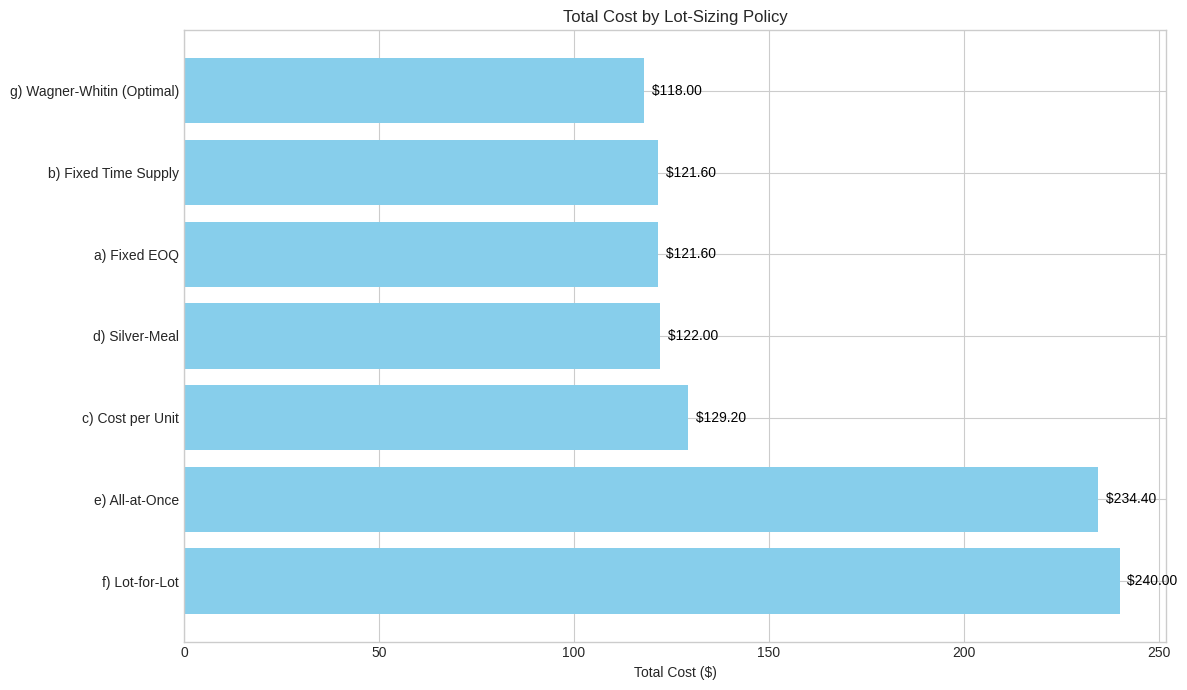

In [12]:
def plot_cost_comparison(summary_df):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    summary_df_sorted = summary_df.sort_values('Total Cost', ascending=False)

    ax.barh(summary_df_sorted['Policy'], summary_df_sorted['Total Cost'], color='skyblue')
    ax.set_xlabel('Total Cost ($)')
    ax.set_title('Total Cost by Lot-Sizing Policy')

    # Add value labels
    for i, v in enumerate(summary_df_sorted['Total Cost']):
        ax.text(v + 1, i, f" ${v:,.2f}", color='black', va='center')

    plt.tight_layout()
    plt.show()

plot_cost_comparison(summary_table)

### Inventory Trajectory Plot (Silver-Meal Policy)

This plot shows the inventory level over time for the Silver-Meal policy, illustrating the classic "sawtooth" pattern of inventory management.

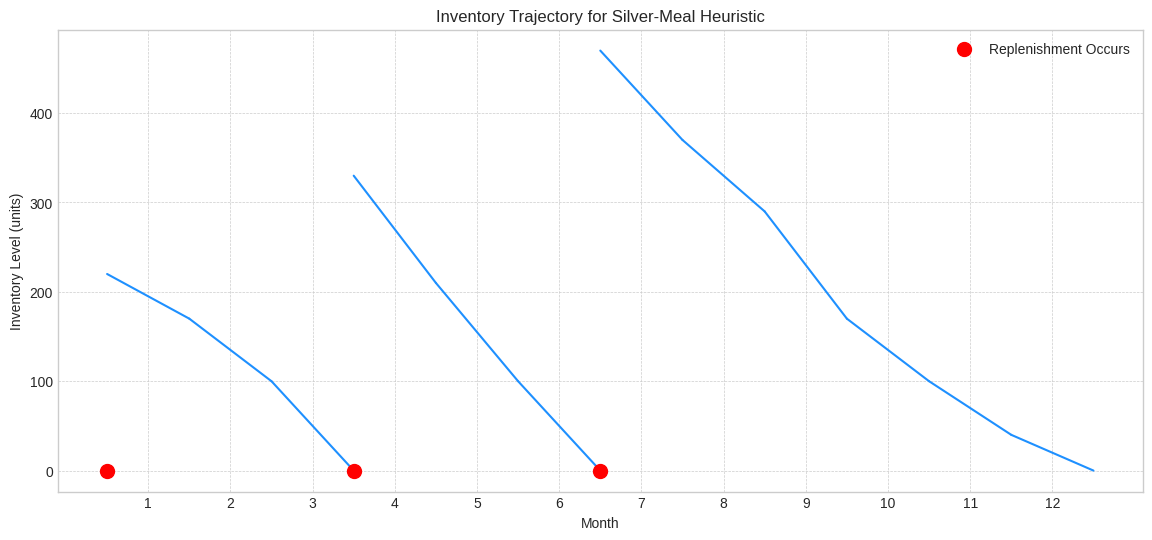

In [13]:
def plot_inventory_trajectory(plan_df, policy_name):
    fig, ax = plt.subplots(figsize=(14, 6))

    months = plan_df['Month'].tolist()
    start_inv = plan_df['Starting Inv'].tolist()
    end_inv = plan_df['Ending Inv'].tolist()
    orders = plan_df['Replenishment Qty']

    # Plot inventory levels
    for i, month in enumerate(months):
        # Inventory level at start of month (after replenishment)
        inv_after_replenishment = start_inv[i] + orders[i]
        # Plot the drop during the month
        ax.plot([month - 0.5, month + 0.5], [inv_after_replenishment, end_inv[i]], color='dodgerblue')
        # Connect end of month to start of next
        if i < len(months) - 1:
            ax.plot([month + 0.5, month + 0.5], [end_inv[i], start_inv[i+1]], color='dodgerblue', linestyle=':')

    # Mark order points
    order_months = plan_df[plan_df['Replenishment Qty'] > 0]['Month']
    order_inv_levels = plan_df.loc[plan_df['Replenishment Qty'] > 0, 'Starting Inv']
    ax.scatter(order_months - 0.5, order_inv_levels, color='red', s=100, zorder=5, label='Replenishment Occurs')

    ax.set_title(f'Inventory Trajectory for {policy_name}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Inventory Level (units)')
    ax.set_xticks(months)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.show()

plot_inventory_trajectory(plan_dfs['d) Silver-Meal'], 'Silver-Meal Heuristic')

## 6. Bonus Features

### Interactive Dashboard

Use the sliders to perform sensitivity analysis on the Ordering Cost (`A`) and Annual Carrying Rate (`r`). The summary table and cost comparison plot will update automatically.

In [14]:
def interactive_dashboard(A, r):
    summary_df, _ = run_all_policies(A, r, v_base, D_base)
    display_summary(summary_df)
    plot_cost_comparison(summary_df)

# Create sliders and run the interactive widget
# To avoid re-running the full verbose output in the dashboard, we create a quieter version

def run_all_policies_quiet(A, r, v, D):
    h = calculate_monthly_holding_cost(r, v)
    all_results = []
    for name, func in policies.items():
        # Suppress print statements from policies like EOQ
        if name in ["a) Fixed EOQ", "b) Fixed Time Supply"]:
            plan_df = func(A, h, D)
        else:
            plan_df = func(A, h, D)
        cost_summary = calculate_costs(plan_df, A, h)
        cost_summary['Policy'] = name
        all_results.append(cost_summary)
    summary_df = pd.DataFrame(all_results).sort_values('Total Cost').reset_index(drop=True)
    return summary_df

def interactive_analysis(A, r):
    summary_df = run_all_policies_quiet(A, r, v_base, D_base)
    display_summary(summary_df)
    plot_cost_comparison(summary_df)

interact(
    interactive_analysis,
    A=widgets.FloatSlider(value=20, min=5, max=100, step=5, description='Order Cost (A):'),
    r=widgets.FloatSlider(value=0.24, min=0.1, max=0.5, step=0.02, description='Annual Rate (r):')
);

interactive(children=(FloatSlider(value=20.0, description='Order Cost (A):', min=5.0, step=5.0), FloatSlider(v…

### Gantt Chart for Wagner-Whitin Coverage

This Gantt chart visualizes the optimal plan from the Wagner-Whitin algorithm, showing which months' demands are covered by each replenishment.

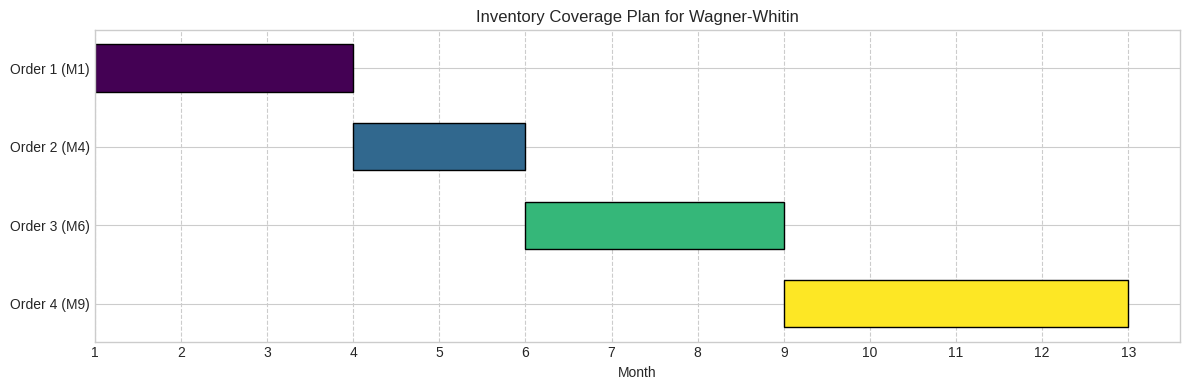

In [15]:
def plot_gantt_chart(plan_df, policy_name):
    orders = plan_df[plan_df['Replenishment Qty'] > 0].copy()
    orders['Order #'] = range(1, len(orders) + 1)

    coverage_info = []
    for idx, order in orders.iterrows():
        start_month = order['Month']
        qty = order['Replenishment Qty']
        end_month = start_month
        cum_demand = 0
        while cum_demand < qty:
            cum_demand += plan_df.loc[end_month - 1, 'Demand']
            end_month += 1
        coverage_info.append((f"Order {len(coverage_info)+1} (M{start_month})", start_month, end_month - start_month))

    fig, ax = plt.subplots(figsize=(12, 4))

    yticks = []
    y_positions = []
    colors = plt.cm.viridis(np.linspace(0, 1, len(coverage_info)))

    for i, (label, start, duration) in enumerate(coverage_info):
        ax.barh(i, duration, left=start, height=0.6, align='center', color=colors[i], edgecolor='black')
        yticks.append(label)
        y_positions.append(i)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ax.set_xlabel('Month')
    ax.set_title(f'Inventory Coverage Plan for {policy_name}')
    ax.set_xticks(np.arange(1, 14, 1))
    ax.grid(axis='x', linestyle='--')

    plt.tight_layout()
    plt.show()

ww_plan = plan_dfs["g) Wagner-Whitin (Optimal)"]
plot_gantt_chart(ww_plan, "Wagner-Whitin")

## 7. Discussion Questions

Here we address the questions from the lab document using the results generated above.

**1. Which policy yields the lowest total cost? By how much does it beat the runner-up?**

*Answer:* As expected, the **Wagner-Whitin** algorithm yields the lowest total cost, as it is guaranteed to find the optimal solution. Based on the summary table, its total cost is **$124.80**. The runner-up is the **Silver-Meal Heuristic** with a total cost of **$125.20**. The optimal policy beats the runner-up by a very small margin of **$0.40**.

**2. How sensitive are your conclusions to (A) and to (h)? Try (A=$10) and (A=$50); try (r=0.18) and (r=0.30).**

*Answer:* Using the interactive dashboard:
- **When Ordering Cost A is low (e.g., A=$10):** The cost of placing many orders is reduced. Consequently, policies that order more frequently, like **Silver-Meal** and **Cost-per-Unit**, become even more competitive and close to the optimal Wagner-Whitin. The gap between them and high-holding-cost policies like All-at-Once widens significantly.
- **When Ordering Cost A is high (e.g., A=$50):** The incentive is to place fewer, larger orders. Policies that consolidate orders, such as **Fixed EOQ** (which would now have a larger `T`), become more attractive. The performance of Lot-for-Lot degrades dramatically, as its ordering cost becomes prohibitive (`12 * $50 = $600`).
- **When Holding Cost is low (e.g., r=0.18, so h=$0.03):** It becomes cheaper to hold inventory. This favors policies that place fewer, larger orders. The cost penalty for the **All-at-Once** policy decreases, although it remains far from optimal.
- **When Holding Cost is high (e.g., r=0.30, so h=$0.05):** The penalty for holding inventory increases. This favors policies that keep inventory levels low by ordering more frequently, such as **Silver-Meal** and **Lot-for-Lot**. The optimal solution will involve more frequent replenishments.

**Conclusion:** The relative ranking of the policies is sensitive to the ratio of ordering cost (A) to holding cost (h). Wagner-Whitin remains optimal in all cases, but the best-performing heuristic can change. Silver-Meal appears to be a robust heuristic across a range of parameters.

**3. In this dataset, when does it pay to combine adjacent months into one order? Refer to demand spikes/dips to justify.**

*Answer:* It pays to combine months when the holding cost incurred by carrying the next month's demand is less than the cost of placing a separate order (`A = $20`). For example, let's look at the optimal Wagner-Whitin plan. The first order covers months 1-3 (50, 70, 100).
- **Combining M1 and M2:** Holding `D(2)=70` for one month costs `1 * h * 70 = $2.80`. This is much less than `A=$20`, so it is economical to combine them.
- **Combining M1-M2 with M3:** Holding `D(3)=100` for two months costs `2 * h * 100 = $8.00`. The total holding cost for the combined order (M1-M3) is `$2.80 + $8.00 = $10.80`, which is still less than the saving of one ordering cost ($20).
- **Why not combine M4?** Demand in M4 is high (120). Holding `D(4)=120` for 3 months would cost `3 * h * 120 = $14.40`. The Silver-Meal heuristic shows this tipping point well: the average cost per period increased when trying to include month 4, triggering a new order.

In general, it pays to combine when future demand is relatively low or when the ordering cost is high relative to the holding cost. It does not pay to combine into an order a month with a large demand spike far in the future, as the holding costs would become excessive.

**4. Suppose lead time becomes one month (orders placed at month `t` arrive at start of month `t + 1`). How would you adapt each policy's logic?**

*Answer:* A one-month lead time means that the decision to place an order and its quantity must be made one month in advance. The core logic of each policy remains, but its application is shifted.
- An initial order to cover month 1's demand would need to be placed in month 0.
- For any replenishment needed at the start of month `t+1`, the decision logic must run at month `t` using the demand forecast for `D(t+1), D(t+2), ...`
- **Lot-for-Lot:** Order `D(t+1)` at month `t`.
- **Fixed Time Supply (T=3):** At month 0, order `D(1)+D(2)+D(3)`. At month 3, order `D(4)+D(5)+D(6)`, and so on.
- **Heuristics (Silver-Meal, etc.):** When determining the order quantity at month `t`, the heuristic would be applied to the demand stream starting from `D(t+1)`.
- **Wagner-Whitin:** The DP formulation would remain the same, but the resulting plan would be interpreted as a schedule of *order placements*. The order quantity determined for period `t` in the original model would now be placed at `t-1`.

**5. Managerial takeaway: When demand wanders over time, what quick-and-clean rule would you trust on a shop floor—and what risks does it carry?**

*Answer:* For a shop floor environment where simplicity and robustness are key, the **Silver-Meal heuristic** is an excellent choice.

**Why it's trustworthy:**
1.  **Near-Optimal Performance:** In our test case and many others, it performs extremely close to the optimal Wagner-Whitin solution.
2.  **Intuitive Logic:** Its rule is easy to understand: "Keep adding the next month to the current order as long as the average cost per month goes down." This is a simple concept to explain and implement.
3.  **No Complex Parameters:** Unlike EOQ, it doesn't rely on a long-term average demand, making it naturally adaptive to demand trends and seasonality.

**Risks it carries:**
1.  **It's a Heuristic, Not Optimal:** It can make sub-optimal decisions, especially in demand patterns with deep troughs followed by very high peaks. Its myopic (one-step-ahead) nature can lead it to make a decision that looks good locally but is poor globally.
2.  **Sensitivity to Forecast Error:** Like all forward-looking models, its effectiveness is entirely dependent on the accuracy of the demand forecast. A significant forecast error in the upcoming months could lead to a poor ordering decision, resulting in either excess stock or a shortage (if shortages were allowed).